In [5]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import utils

importlib.reload(utils)

# InteractiveShell.ast_node_interactivity = "all"

from src.datahandlers import PacmanDataReader

In [6]:
data = PacmanDataReader(data_folder="../../data/", read_games_only=False)

user_df = data.user_df
game_df = data.game_df
gamestate_df = data.gamestate_df
psychometrics_df = data.psychometrics_df

In [7]:
# TODO implement this in DataReader class

bisbas_df = psychometrics_df.loc[
    ~psychometrics_df["redcap_repeat_instrument"].isin(["flow", "sam"])
    & psychometrics_df["consent_timestamp"].notna()
    & (psychometrics_df["record_id"] > 60)
].drop(
    columns=[
        "name",
        "email",
        "redcap_repeat_instrument",
        "redcap_repeat_instance",
        "redcap_survey_identifier",
        "consent_timestamp",
        "flow_complete",
    ]
)

bisbas_df["BIS"] = bisbas_df.loc[
    :, ["bis_1", "bis_2", "bis_3", "bis_4", "bis_5", "bis_6", "bis_7"]
].sum(axis=1)
bisbas_df["REW"] = bisbas_df.loc[:, ["rew_1", "rew_2", "rew_3", "rew_4", "rew_5"]].sum(
    axis=1
)
bisbas_df["DRIVE"] = bisbas_df.loc[:, ["drive_1", "drive_2", "drive_3", "drive_4"]].sum(
    axis=1
)
bisbas_df["FUN"] = bisbas_df.loc[:, ["fun_1", "fun_2", "fun_3", "fun_4"]].sum(axis=1)


bisbas_df = bisbas_df.loc[
    :,
    ["record_id", "age", "gender", "nationality", "edu", "BIS", "REW", "DRIVE", "FUN"],
]

bisbas_df = bisbas_df.rename(columns={"record_id": "user_id"})
bisbas_df

,user_id,age,gender,nationality,edu,BIS,REW,DRIVE,FUN
65,64,25.0,1.0,Spanish,5.0,19.0,15.0,8.0,11.0
73,66,27.0,1.0,Finnish,4.0,18.0,20.0,13.0,13.0
74,67,35.0,1.0,USA,5.0,20.0,16.0,11.0,14.0
76,68,24.0,2.0,Spanish,5.0,17.0,17.0,11.0,13.0
79,69,25.0,2.0,Finnish,5.0,20.0,17.0,10.0,12.0
...,...,...,...,...,...,...,...,...,...
615,206,28.0,2.0,Finnish,5.0,20.0,12.0,6.0,9.0
619,207,22.0,2.0,suomalainen,3.0,21.0,19.0,9.0,11.0
623,208,29.0,2.0,Finnish,3.0,23.0,14.0,9.0,14.0
629,209,25.0,2.0,Finnish,4.0,23.0,17.0,4.0,13.0


C:\Users\Localadmin_pabflore\AppData\Local\Temp\ipykernel_1616\4124247477.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[i, j] = f"{correlation_matrix.loc[i, j]:.2f}*"
C:\Users\Localadmin_pabflore\AppData\Local\Temp\ipykernel_1616\4124247477.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.09' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[i, j] = f"{correlation_matrix.loc[i, j]:.2f}"
C:\Users\Localadmin_pabflore\AppData\Local\Temp\ipykernel_1616\4124247477.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03' has dtype incompatible with float64, plea

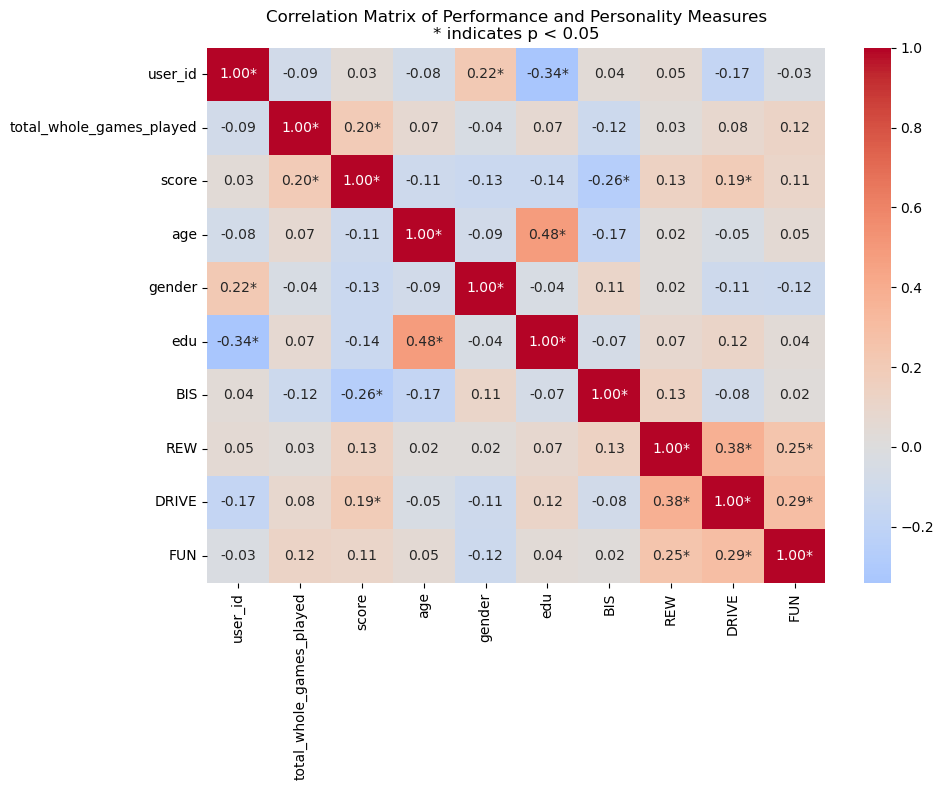

In [11]:
from scipy import stats
import seaborn as sns

whole_games = game_df.loc[(game_df["win"] == 0)]

whole_games_scores = (
    gamestate_df.loc[gamestate_df["game_id"].isin(whole_games["game_id"])]
    .groupby("game_id")
    .agg({"score": "max"})
)

whole_games = pd.merge(whole_games, whole_games_scores, how="outer", on="game_id")

whole_games["total_whole_games_played"] = whole_games.groupby("user_id").cumcount() + 1


user_overall = (
    whole_games.groupby("user_id")
    .agg({"total_whole_games_played": "max", "score": "max"})
    .reset_index()
)
user_overall.sort_values(by="total_whole_games_played", ascending=False)

bisbas_perf = pd.merge(user_overall, bisbas_df, how="inner", on="user_id")
# Calculate correlation matrix and p-values
numeric_cols = bisbas_perf.select_dtypes(include=["float64", "int64"]).columns
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols, dtype=float)
p_values = pd.DataFrame(index=numeric_cols, columns=numeric_cols, dtype=float)

for i in numeric_cols:
    for j in numeric_cols:
        corr, pval = stats.spearmanr(bisbas_perf[i], bisbas_perf[j])
        correlation_matrix.loc[i, j] = corr
        p_values.loc[i, j] = pval

# Create annotation matrix with asterisks for significant correlations
annot_matrix = correlation_matrix.copy()
for i in numeric_cols:
    for j in numeric_cols:
        if p_values.loc[i, j] < 0.05:
            annot_matrix.loc[i, j] = f"{correlation_matrix.loc[i, j]:.2f}*"
        else:
            annot_matrix.loc[i, j] = f"{correlation_matrix.loc[i, j]:.2f}"

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix.astype(float),
    annot=annot_matrix,
    cmap="coolwarm",
    center=0,
    fmt="",
)
plt.title(
    "Correlation Matrix of Performance and Personality Measures\n* indicates p < 0.05"
)
plt.tight_layout()
plt.show()

In [13]:
stats.spearmanr(bisbas_perf["DRIVE"], bisbas_perf["score"])

SignificanceResult(statistic=np.float64(0.19373122534392379), pvalue=np.float64(0.048779841703932056))